In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd

## Def functions: One-Hot Encoding and Split Data (Dataframe)

In [307]:
def Get_ListOfLabels(df_InputLabels):
    df_Tags = df_InputLabels.str.split(expand=True)
    columns = len(df_Tags.columns)

    for i in range(columns):
        if i == 0:
            df_aux = pd.DataFrame(df_Tags[0])
        else:
            df_aux = df_aux.append(pd.DataFrame(df_Tags[i].rename(index=0)))

    LabelList = (df_aux.drop_duplicates().sort_values([0], ascending=[True]))[0].tolist()
    LabelList = list(filter(None, LabelList))
    return LabelList


def Get_LabelEncodedArray(df_InputLabels, LabelList):
    LabelArray = np.zeros((df_InputLabels.count(), len(LabelList)))
    TagsArray = df_InputLabels.str.split(expand=True).to_numpy()

    for i in range(TagsArray.shape[0]):
        for j in range(TagsArray.shape[1]):
            for k in range(len(LabelList)):
                if(TagsArray[i][j]== LabelList[k]):
                    LabelArray[i][k] = 1

    return LabelArray


def SplitData(df_Dataset, Ratio):

    df_TrainData = pd.DataFrame(df_Dataset).sample(round(Ratio * df_Dataset['filename'].count()))

    df_ValData = pd.DataFrame(df_Dataset)
    condition = df_ValData['filename'].isin(df_TrainData['filename'])
    df_ValData = df_ValData.drop(df_ValData[condition].index)

    return df_TrainData, df_ValData

- Coding labels -> One-Hot Encoding

In [268]:
source_path = "raw-data"
source_path_Labels = os.path.join(source_path, 'train_v2.csv')
source_path_Images = os.path.join(source_path, 'train-jpg')

df_Raw = pd.read_csv(source_path_Labels)
LabelList = Get_ListOfLabels(df_Raw.tags)

Get_LabelEncodedArray(df_Raw.tags, LabelList)
df_Dataset = pd.DataFrame(Get_LabelEncodedArray(df_Raw.tags, LabelList), columns=LabelList)
df_Dataset['filename'] = df_Raw.image_name.to_list()
df_Dataset['filename'] = df_Dataset['filename']+'.jpg'
df_Dataset = df_Dataset.loc[: , ['filename']+LabelList]

## Training and Validation Generators

Now that you know the images you are dealing with, it is time for you to code the generators that will fed these images to your Network. For this, complete the `train_val_generators` function below:

**Important Note:** The images have a resolution of 300x300 but the `flow_from_directory` method you will use allows you to set a target resolution. In this case, **set a `target_size` of (150, 150)**. This will heavily lower the number of trainable parameters in your final network, yielding much quicker training times without compromising the accuracy!

In [358]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(DIRECTORY, df_Train, df_Validation):
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values and set arguments to augment the images 
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                    #  rotation_range=15,
                                    #  width_shift_range=0.1,
                                    #  height_shift_range=0.1,
                                    #  zoom_range=0.1,
                                    #  horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_dataframe method
  train_generator = train_datagen.flow_from_dataframe(dataframe=df_Train,
                                                      directory=DIRECTORY,
                                                      x_col=df_Train.columns[0],
                                                      y_col=df_Train.columns[1:len(df_Train.columns)],
                                                      batch_size=32, 
                                                      class_mode='raw',
                                                      target_size=(256, 256))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

  # Pass in the appropriate arguments to the flow_from_dataframe method
  validation_generator = validation_datagen.flow_from_dataframe(dataframe=df_Validation,
                                                                directory=DIRECTORY,
                                                                x_col=df_ValData.columns[0],
                                                                y_col=df_ValData.columns[1:len(df_ValData.columns)],
                                                                batch_size=32, 
                                                                class_mode='raw',
                                                                target_size=(256, 256))
  ### END CODE HERE
  return train_generator, validation_generator

In [359]:
# Split Data
TrainToValidation_DataSize_Ratio = 0.8
df_TrainData, df_ValData = SplitData(df_Dataset, TrainToValidation_DataSize_Ratio)

# Test Generators
train_generator, validation_generator = train_val_generators(source_path_Images, df_TrainData, df_ValData)

Found 32383 validated image filenames.
Found 8096 validated image filenames.


## Model Definition

In [376]:
from tensorflow.keras.optimizers import RMSprop
import tensorflow_addons as tfa

NumOfClasses = len(df_Dataset.columns)-1

def create_model():
  model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(NumOfClasses, activation='sigmoid')
  ])

  
  model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['Precision', 'Recall', tfa.metrics.F1Score(num_classes=NumOfClasses, average='micro',threshold=0.5), 'CategoricalAccuracy']) 
    
  ### END CODE HERE

  return model

## Model Training

In [377]:
# Get the untrained model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
1012/1012 [==============================] - 717s 708ms/step - loss: 0.2083 - precision: 0.8310 - recall: 0.6531 - f1_score: 0.7314 - categorical_accuracy: 0.0333 - val_loss: 0.1688 - val_precision: 0.8956 - val_recall: 0.6855 - val_f1_score: 0.7766 - val_categorical_accuracy: 0.0411
Epoch 2/15
1012/1012 [==============================] - 696s 688ms/step - loss: 0.1663 - precision: 0.8665 - recall: 0.7310 - f1_score: 0.7930 - categorical_accuracy: 0.0476 - val_loss: 0.1716 - val_precision: 0.8480 - val_recall: 0.7576 - val_f1_score: 0.8002 - val_categorical_accuracy: 0.0413
Epoch 3/15
1012/1012 [==============================] - 693s 684ms/step - loss: 0.1548 - precision: 0.8786 - recall: 0.7533 - f1_score: 0.8111 - categorical_accuracy: 0.0527 - val_loss: 0.1507 - val_precision: 0.8785 - val_recall: 0.7631 - val_f1_score: 0.8167 - val_categorical_accuracy: 0.0573
Epoch 4/15
1012/1012 [==============================] - 692s 683ms/step - loss: 0.1457 - precision: 0.8846 - rec

## Plot History

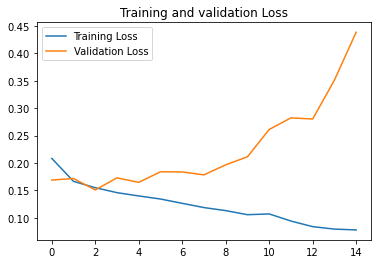

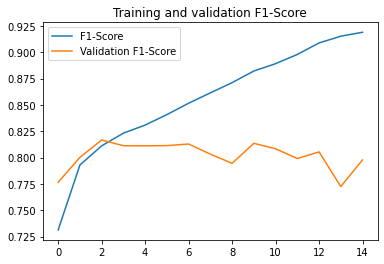

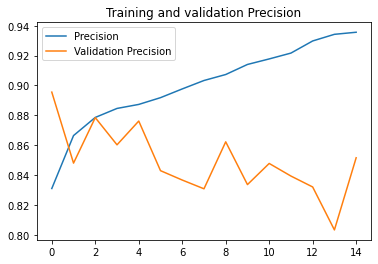

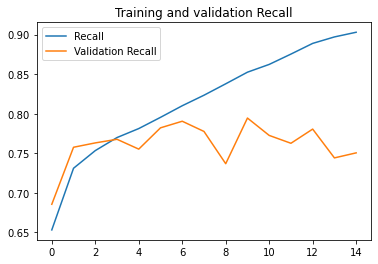

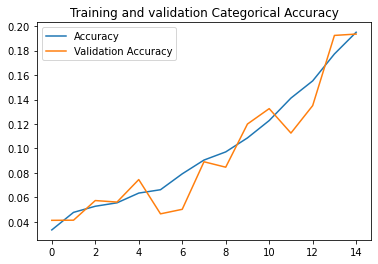

In [389]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']
val_loss=history.history['val_loss']

f1=history.history['f1_score']
val_f1 = history.history['val_f1_score']

recall = history.history['recall']
val_recall = history.history['val_recall']

precision = history.history['precision']
val_precision = history.history['val_precision']

acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title('Training and validation Loss')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation F1-Score per epoch
#------------------------------------------------
plt.plot(epochs, f1, label="F1-Score")
plt.plot(epochs, val_f1, label="Validation F1-Score")
plt.title('Training and validation F1-Score')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation Precision per epoch
#------------------------------------------------
plt.plot(epochs, precision, label="Precision")
plt.plot(epochs, val_precision, label="Validation Precision")
plt.title('Training and validation Precision')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation Recall per epoch
#------------------------------------------------
plt.plot(epochs, recall, label="Recall")
plt.plot(epochs, val_recall, label="Validation Recall")
plt.title('Training and validation Recall')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation Recall per epoch
#------------------------------------------------
plt.plot(epochs, acc, label="Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title('Training and validation Categorical Accuracy')
plt.legend()
plt.show()


print("")

## Save History to Pickle file

In [392]:
def download_history():
  import pickle

  with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history.history, f)

download_history()